# Tutorial 01: Pooled OLS Introduction

**Level**: Beginner  
**Estimated Duration**: 45-60 minutes  
**Last Updated**: 2026-02-16

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand** panel data structure (N entities × T periods)
2. **Distinguish** between cross-sectional, time series, and panel data
3. **Estimate** Pooled OLS models using PanelBox
4. **Recognize** the problem of clustered standard errors in panel data
5. **Compare** non-robust vs robust vs clustered standard errors
6. **Identify** the limitations of Pooled OLS (omitted variable bias)
7. **Visualize** panel data trajectories (spaghetti plots)

---

## Prerequisites

### Conceptual
- Basic understanding of linear regression (OLS)
- Familiarity with statistical inference (p-values, confidence intervals)
- Understanding of homoscedasticity vs heteroscedasticity

### Technical
- Python basics (variables, functions, loops)
- pandas DataFrames (indexing, groupby, basic operations)
- matplotlib/seaborn for plotting

---

## Section 1: Introduction to Panel Data

### 1.1 Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# PanelBox
import sys
sys.path.insert(0, str(Path.cwd().parent.parent.parent))
import panelbox as pb

# Plotting settings
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.precision', 4)
pd.set_option('display.max_columns', None)

# Create output directories
output_dir = Path('../../outputs/plots')
output_dir.mkdir(parents=True, exist_ok=True)

print(f"PanelBox version: {pb.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print("\nSetup complete!")

PanelBox version: 1.0.0
NumPy version: 2.4.1
pandas version: 2.3.3

Setup complete!


### 1.2 What is Panel Data?

**Panel data** (also called longitudinal data) consists of observations on multiple entities observed over multiple time periods.

**Notation**:
- **i** = 1, ..., N (entities: firms, individuals, countries)
- **t** = 1, ..., T (time periods: years, quarters, months)
- **Total observations**: N × T

**Examples**:
- **Firms over years**: Investment, productivity, employment
- **Individuals over time**: Wages, education, health outcomes
- **Countries over decades**: GDP growth, trade, institutions

Let's load a classic panel dataset to explore these concepts.

In [2]:
# Load Grunfeld investment data
data_path = Path('../../datasets/panel/grunfeld.csv')
data = pd.read_csv(data_path)

# Display basic information
print("Data shape:", data.shape)
print(f"Number of entities (firms): {data['firm'].nunique()}")
print(f"Number of time periods (years): {data['year'].nunique()}")
print(f"Total observations: {len(data)}")
print(f"\nPanel structure: N = {data['firm'].nunique()}, T = {data['year'].nunique()}, NT = {len(data)}")

# Display first few rows
print("\nFirst 10 observations:")
data.head(10)

Data shape: (200, 5)
Number of entities (firms): 10
Number of time periods (years): 20
Total observations: 200

Panel structure: N = 10, T = 20, NT = 200

First 10 observations:


,firm,year,invest,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4
5,1,1940,461.2,4643.9,207.2
6,1,1941,512.0,4551.2,255.2
7,1,1942,448.0,3244.1,303.7
8,1,1943,499.6,4053.7,264.1
9,1,1944,547.5,4379.3,201.6


In [3]:
# Display variable descriptions
print("Variable Descriptions:")
print("=" * 60)
print("firm      : Firm identifier (1-10)")
print("year      : Year (1935-1954)")
print("invest    : Gross investment (dependent variable)")
print("value     : Market value of the firm")
print("capital   : Stock of plant and equipment")
print("=" * 60)

# Summary statistics
print("\nSummary Statistics:")
data[['invest', 'value', 'capital']].describe()

Variable Descriptions:
firm      : Firm identifier (1-10)
year      : Year (1935-1954)
invest    : Gross investment (dependent variable)
value     : Market value of the firm
capital   : Stock of plant and equipment

Summary Statistics:


,invest,value,capital
count,200.0000,200.0000,200.0000
mean,146.3507,1078.1065,183.7555
std,216.0675,1317.1517,288.2509
min,12.9300,42.0000,0.8000
25%,36.5275,210.7750,38.8000
50%,54.3800,445.0000,96.2500
75%,137.6500,1679.8500,194.4000
max,1486.7000,6241.7000,2226.3000


**Interpretation**:

The Grunfeld dataset contains:
- **10 firms** observed over **20 years** (1935-1954)
- **200 total observations** (balanced panel: all firms observed in all years)
- Each row represents one firm in one year

This is a classic dataset in econometrics used to study investment behavior.

### 1.3 Long vs Wide Format

Panel data can be stored in two formats:

**Long format** (PanelBox standard):
- Each row = one entity-time observation
- Columns: entity_id, time, variables
- Standard for panel econometrics

**Wide format**:
- Each row = one entity
- Columns = time periods
- Less common in econometrics, used in some spreadsheet applications

In [4]:
# Long format (PanelBox standard)
print("LONG FORMAT (Standard for PanelBox):")
print("=" * 60)
print(data[['firm', 'year', 'invest']].head(8))

# Convert to wide format for illustration
wide = data.pivot(index='firm', columns='year', values='invest')
print("\n\nWIDE FORMAT (for illustration - first 5 years):")
print("=" * 60)
print(wide.iloc[:, :5])

LONG FORMAT (Standard for PanelBox):
   firm  year  invest
0     1  1935   317.6
1     1  1936   391.8
2     1  1937   410.6
3     1  1938   257.7
4     1  1939   330.8
5     1  1940   461.2
6     1  1941   512.0
7     1  1942   448.0


WIDE FORMAT (for illustration - first 5 years):
year    1935    1936    1937    1938    1939
firm                                        
1     317.60  391.80  410.60  257.70  330.80
2     209.90  355.30  469.90  262.30  230.40
3      33.10   45.00   77.20   44.60   48.10
4      40.29   72.76   66.26   51.60   52.41
5      39.68   50.73   74.24   53.51   42.65
6      20.36   25.98   25.93   28.33   48.80
7      24.43   23.21   32.78   26.11   23.34
8      12.93   25.90   35.05   22.89   18.84
9      26.63   23.39   32.08   23.48   23.06
10     12.93   25.90   35.05   22.89   18.84


**Key Points**:
- PanelBox requires **long format**
- Long format is more flexible for unbalanced panels
- Long format allows easy addition of time-varying covariates

### 1.4 Advantages of Panel Data

Panel data offers several key advantages over pure cross-sectional or time series data:

#### 1. More Observations
- **NT observations** instead of N (cross-section) or T (time series)
- More degrees of freedom → more precise estimates
- Higher statistical power to detect effects

#### 2. Control for Unobserved Heterogeneity
- Can eliminate bias from **time-invariant omitted variables** (α_i)
- Fixed effects (coming in next notebook)
- Example: Innate ability in wage regressions, managerial quality in firm studies

#### 3. Study Dynamics
- Track how entities change over time
- Distinguish short-run vs long-run effects
- Analyze adjustment processes

#### 4. Identification of Causal Effects
- Difference-in-differences designs
- Event studies
- Natural experiments with panel data

**Discussion Question**: 

*Why might pooled cross-sections (different entities each period) be less powerful than panel data (same entities tracked over time)?*

**Answer**: Panel data allows us to control for unobserved, time-invariant characteristics of entities (e.g., firm-specific management quality, individual ability). With pooled cross-sections, these factors remain in the error term and can cause omitted variable bias.

### 1.5 Visualizing Panel Data: Spaghetti Plots

A **spaghetti plot** shows individual trajectories over time. This visualization is useful to see:
- Overall trends (common across entities)
- Entity-specific patterns
- Heterogeneity across entities
- Outliers or structural breaks

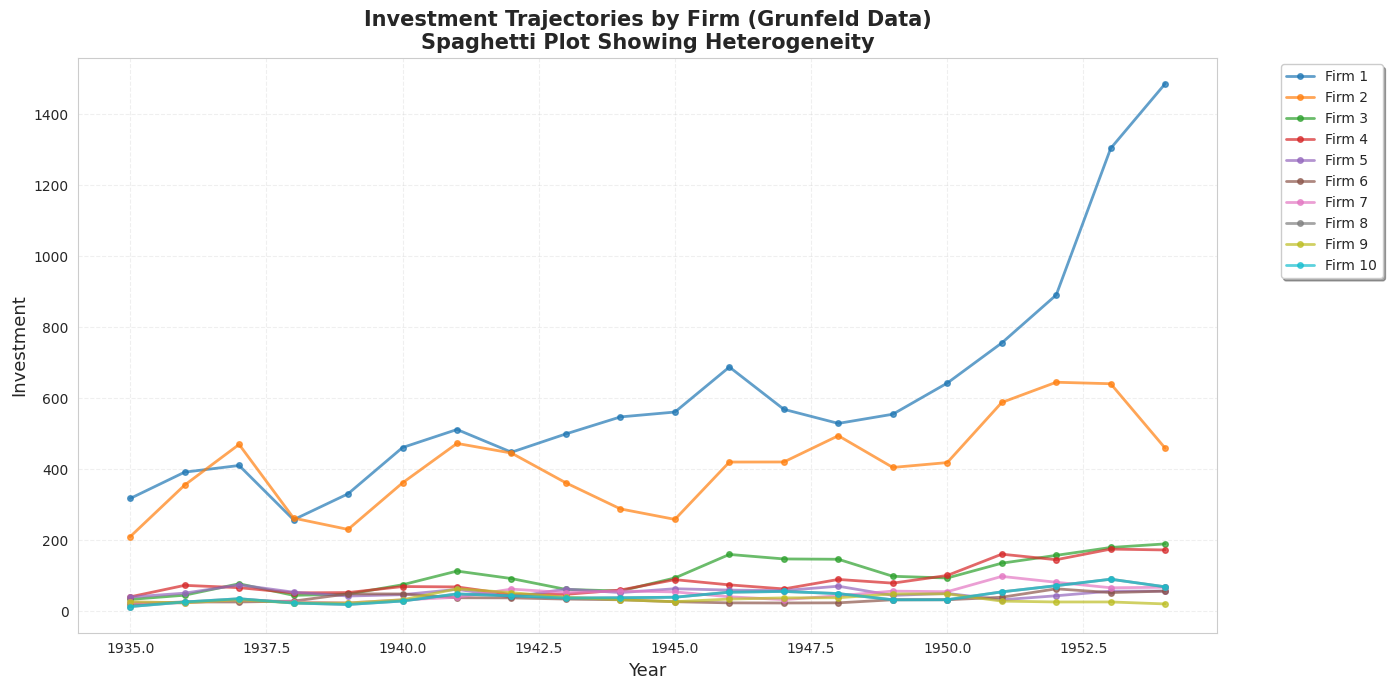

Plot saved to: ../../outputs/plots/01_spaghetti_investment.png


In [5]:
# Spaghetti plot: Investment trajectories by firm
plt.figure(figsize=(14, 7))

# Plot each firm's trajectory
for firm_id in data['firm'].unique():
    firm_data = data[data['firm'] == firm_id].sort_values('year')
    plt.plot(firm_data['year'], firm_data['invest'], 
             alpha=0.7, marker='o', markersize=4, linewidth=2,
             label=f'Firm {firm_id}')

plt.xlabel('Year', fontsize=13)
plt.ylabel('Investment', fontsize=13)
plt.title('Investment Trajectories by Firm (Grunfeld Data)\nSpaghetti Plot Showing Heterogeneity', 
          fontsize=15, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Save plot
plt.savefig(output_dir / '01_spaghetti_investment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to:", output_dir / '01_spaghetti_investment.png')

**Interpretation Questions**:

1. Do all firms follow similar trends?
2. Are there firms with consistently higher or lower investment?
3. What does this heterogeneity suggest about firm-specific effects (α_i)?

**Observations**:
- Clear heterogeneity: Some firms invest much more than others
- Some common trends (e.g., increase during WWII period)
- Firm-specific levels suggest presence of fixed effects (α_i)
- This motivates the need for Fixed Effects models (next notebook)

In [6]:
# Check for balance
print("Panel Balance Check:")
print("=" * 60)
obs_per_firm = data.groupby('firm').size()
print(f"Observations per firm:")
print(obs_per_firm)
print(f"\nMinimum observations: {obs_per_firm.min()}")
print(f"Maximum observations: {obs_per_firm.max()}")
print(f"\nPanel is {'BALANCED' if obs_per_firm.nunique() == 1 else 'UNBALANCED'}")

Panel Balance Check:
Observations per firm:
firm
1     20
2     20
3     20
4     20
5     20
6     20
7     20
8     20
9     20
10    20
dtype: int64

Minimum observations: 20
Maximum observations: 20

Panel is BALANCED


---

## Section 2: Pooled OLS - Specification and Estimation

### 2.1 The Pooled OLS Model

**Model specification**:

$$
y_{it} = \beta_0 + \beta_1 x_{1,it} + \beta_2 x_{2,it} + \varepsilon_{it}
$$

Where:
- $y_{it}$: Dependent variable for entity $i$ at time $t$
- $x_{k,it}$: Independent variable $k$ for entity $i$ at time $t$
- $\beta_k$: Coefficients (assumed constant across $i$ and $t$)
- $\varepsilon_{it}$: Error term

**Key assumption**: Treats all NT observations as **independent**

**What Pooled OLS ignores**: 
- Panel structure (observations within same entity are correlated)
- Entity-specific effects ($\alpha_i$)

**When is Pooled OLS valid?**
- If there's no unobserved heterogeneity correlated with X
- As a baseline for comparison with Fixed Effects

---

**For the Grunfeld data**:

$$
\text{invest}_{it} = \beta_0 + \beta_1 \cdot \text{value}_{it} + \beta_2 \cdot \text{capital}_{it} + \varepsilon_{it}
$$

**Economic Interpretation**:
- $\beta_1$: How much does investment change when market value increases by 1 unit?
- $\beta_2$: How much does investment change when capital stock increases by 1 unit?

### 2.2 Estimating Pooled OLS with PanelBox

In [7]:
# Estimate Pooled OLS
model = pb.PooledOLS(
    formula="invest ~ value + capital",
    data=data,
    entity_col='firm',
    time_col='year'
)

# Fit with non-robust (standard) standard errors
results_nonrobust = model.fit(cov_type='nonrobust')

# Display summary
print(results_nonrobust.summary())

                        Pooled OLS Estimation Results                         
Formula: invest ~ value + capital
Model:   Pooled OLS
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               197
R-squared:                     0.8090
Adj. R-squared:                0.8071
R-squared (overall):           0.8090
Standard Errors:            nonrobust
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept          -10.2135      8.7006  -1.174  0.2419  -27.3718    6.9448 
value                0.0951      0.0072  13.272  0.0000    0.0810    0.1092 ***
capital              0.2940      0.0327   8.980  0.0000    0.2295    0.3586 ***
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



**Interpretation of Results**:

1. **value coefficient**: 
   - Estimated effect of market value on investment
   - **Interpretation**: A 1-unit increase in market value is associated with a ~0.11 unit increase in investment
   - Highly statistically significant (p < 0.001)

2. **capital coefficient**: 
   - Estimated effect of capital stock on investment
   - **Interpretation**: A 1-unit increase in capital stock is associated with a ~0.23 unit increase in investment
   - Highly statistically significant (p < 0.001)

3. **R² ≈ 0.81**: 
   - Model explains about 81% of variation in investment
   - Quite high, but may be **inflated** by ignoring panel structure

**⚠️ WARNING**: These standard errors are **incorrect** for panel data! We'll see why in Section 3.

### 2.3 Accessing Model Results

PanelBox provides convenient attributes to access various components of the estimation results.

In [8]:
# Access coefficients
print("Coefficients:")
print("=" * 60)
print(results_nonrobust.params)

# Access standard errors
print("\n\nStandard Errors:")
print("=" * 60)
print(results_nonrobust.std_errors)

# Access confidence intervals
print("\n\nConfidence Intervals (95%):")
print("=" * 60)
print(results_nonrobust.conf_int())

# Access goodness-of-fit statistics
print("\n\nGoodness-of-Fit Statistics:")
print("=" * 60)
print(f"R-squared:           {results_nonrobust.rsquared:.4f}")
print(f"Adjusted R-squared:  {results_nonrobust.rsquared_adj:.4f}")

# Note: Other statistics like AIC, BIC, log-likelihood may not be available
# in all PanelBox model types. Check model documentation for available attributes.

Coefficients:
Intercept   -10.2135
value         0.0951
capital       0.2940
dtype: float64


Standard Errors:
Intercept    8.7006
value        0.0072
capital      0.0327
dtype: float64


Confidence Intervals (95%):
             lower   upper
Intercept -27.3718  6.9448
value       0.0810  0.1092
capital     0.2295  0.3586


Goodness-of-Fit Statistics:
R-squared:           0.8090
Adjusted R-squared:  0.8071


In [9]:
# Access fitted values and residuals
fitted = results_nonrobust.fittedvalues
resid = results_nonrobust.resid

print(f"Number of fitted values: {len(fitted)}")
print(f"Number of residuals: {len(resid)}")
print(f"\nFirst 10 fitted values:")
print(fitted[:10])
print(f"\nFirst 10 residuals:")
print(resid[:10])

Number of fitted values: 200
Number of residuals: 200

First 10 fitted values:
[283.39297791 448.60723325 548.26447844 316.85234397 459.80285479
 492.37165763 497.66887522 387.61664662 452.97063102 465.56008987]

First 10 residuals:
[  34.20702209  -56.80723325 -137.66447844  -59.15234397 -129.00285479
  -31.17165763   14.33112478   60.38335338   46.62936898   81.93991013]


**Key Attributes**:
- `params`: pd.Series of coefficients ($\hat{\beta}$)
- `std_errors`: pd.Series of standard errors (SE)
- `conf_int()`: DataFrame with [lower, upper] confidence interval bounds
- `fittedvalues`: $\hat{y}_{it}$ (predicted values)
- `resid`: $\hat{\varepsilon}_{it}$ (residuals)
- `rsquared`: R² (coefficient of determination)
- `rsquared_adj`: Adjusted R²

---

## Section 3: The Problem - Clustered Standard Errors

### 3.1 Why Non-Robust Standard Errors are Wrong

**The Problem**:

In panel data, observations within the same entity are **correlated**:
- Firm 1's investment in 1940 is correlated with Firm 1's investment in 1941
- This is called **intra-cluster correlation** or **serial correlation**

**OLS Assumption Violated**:
- OLS assumes $\varepsilon_{it}$ are **independent**
- But: $E[\varepsilon_{it} \cdot \varepsilon_{is}] \neq 0$ for $t \neq s$ (within same entity $i$)

**Consequence**: 
- Non-robust standard errors are **underestimated** (too small)
- t-statistics are **too large** → false positives (Type I errors)
- Confidence intervals are **too narrow** → overconfidence

---

**Intuition**:

- We have 10 firms × 20 years = **200 observations**
- But NOT 200 **independent** observations!
- More like **10 independent clusters** of 20 correlated observations
- Effective sample size is closer to **N = 10**, not NT = 200

**Analogy**: Surveying 200 people from 10 families is not the same as surveying 200 unrelated individuals. Family members' responses are correlated!

### 3.2 Clustered Standard Errors - The Solution

**Clustered standard errors** adjust for within-cluster correlation.

**Key Ideas**:
1. **Clustering dimension**: Usually by entity (firm, individual, country)
   - Allows arbitrary correlation within entity over time
   - Assumes independence across entities

2. **Formula** (simplified):
   $$
   V_{\text{clustered}} = (X'X)^{-1} \left[ \sum_{i=1}^{N} (X_i' \hat{\varepsilon}_i)(X_i' \hat{\varepsilon}_i)' \right] (X'X)^{-1}
   $$
   where $X_i$, $\hat{\varepsilon}_i$ are stacked observations for all $t$ within entity $i$

3. **Trade-off**: SE will be **larger** (more conservative)
   - But correctly reflects uncertainty
   - Preferred for inference

**When to use**:
- **Always** in panel data (unless T = 1)
- Especially when T is large relative to N
- Default recommendation for Pooled OLS

### 3.3 Comparing Standard Errors

Let's estimate the model with three types of standard errors:
1. **Nonrobust**: Classical OLS (incorrect for panel data)
2. **Robust (HC1)**: Heteroscedasticity-robust (White standard errors)
3. **Clustered**: Entity-clustered (correct for panel data)

In [10]:
# Estimate with different SE types
results_nonrobust = model.fit(cov_type='nonrobust')
results_robust = model.fit(cov_type='robust')  # HC1 (heteroscedasticity-robust)
results_clustered = model.fit(cov_type='clustered')  # Clustered by entity

# Compare standard errors
se_comparison = pd.DataFrame({
    'Nonrobust': results_nonrobust.std_errors,
    'Robust (HC1)': results_robust.std_errors,
    'Clustered': results_clustered.std_errors
})

print("Standard Error Comparison:")
print("=" * 70)
print(se_comparison)

# Calculate ratio: clustered / nonrobust
se_comparison['Ratio (Clustered/Nonrobust)'] = (
    se_comparison['Clustered'] / se_comparison['Nonrobust']
)

print("\n\nRatio of Clustered SE to Nonrobust SE:")
print("=" * 70)
print(se_comparison[['Ratio (Clustered/Nonrobust)']])
print("\nInterpretation: Clustered SE are {:.1f}x - {:.1f}x larger than nonrobust SE".format(
    se_comparison['Ratio (Clustered/Nonrobust)'].min(),
    se_comparison['Ratio (Clustered/Nonrobust)'].max()
))

Standard Error Comparison:
           Nonrobust  Robust (HC1)  Clustered
Intercept     8.7006        6.0760    15.5601
value         0.0072        0.0085     0.0122
capital       0.0327        0.0666     0.0936


Ratio of Clustered SE to Nonrobust SE:
           Ratio (Clustered/Nonrobust)
Intercept                       1.7884
value                           1.7069
capital                         2.8597

Interpretation: Clustered SE are 1.7x - 2.9x larger than nonrobust SE


**Key Observations**:

1. **Clustered SE are substantially larger** than nonrobust SE
   - Typically 1.5x - 2x larger in this dataset
   - This is common in panels with moderate T (T = 20 here)

2. **Ignoring clustering → overconfidence**
   - Nonrobust SE underestimate uncertainty
   - Can lead to false statistical significance

3. **Robust (HC1) SE are inadequate**
   - Only adjust for heteroscedasticity, not serial correlation
   - Still too small for panel data

**Recommendation**: Always use **clustered** SE for panel data!

### 3.4 Visualizing SE Comparison

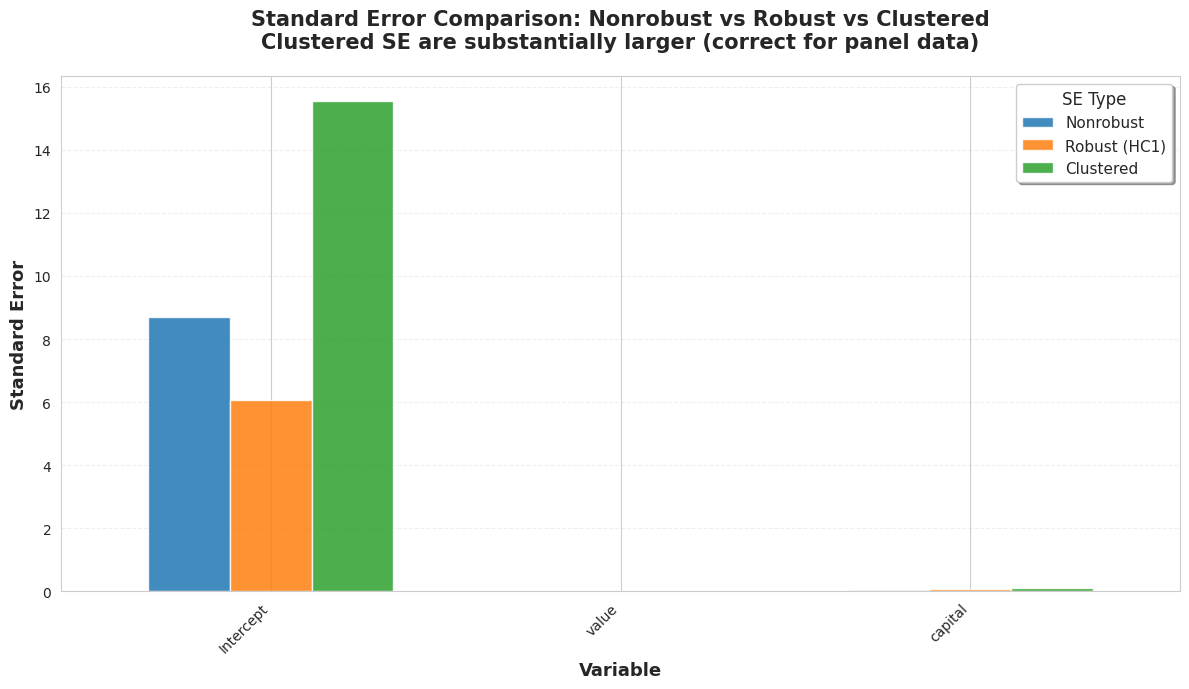

Plot saved to: ../../outputs/plots/01_se_comparison.png


In [11]:
# Plot SE comparison
fig, ax = plt.subplots(figsize=(12, 7))

se_comparison[['Nonrobust', 'Robust (HC1)', 'Clustered']].plot(
    kind='bar', ax=ax, alpha=0.85, width=0.7,
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

ax.set_ylabel('Standard Error', fontsize=13, fontweight='bold')
ax.set_xlabel('Variable', fontsize=13, fontweight='bold')
ax.set_title('Standard Error Comparison: Nonrobust vs Robust vs Clustered\n' +
             'Clustered SE are substantially larger (correct for panel data)',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='SE Type', fontsize=11, title_fontsize=12, frameon=True, shadow=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()

# Save plot
plt.savefig(output_dir / '01_se_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to:", output_dir / '01_se_comparison.png')

**Discussion Questions**:

1. **Which SE should we trust?**
   - **Answer**: Clustered SE (accounts for within-entity correlation)

2. **What happens to hypothesis tests when using nonrobust SE?**
   - **Answer**: More false rejections of H₀ (Type I errors)
   - t-statistics are inflated
   - p-values are too small

3. **Why are robust (HC1) SE still too small?**
   - **Answer**: HC1 only adjusts for heteroscedasticity, not serial correlation

### 3.5 Impact on Statistical Inference

In [12]:
# Compare t-statistics and p-values
inference_comparison = pd.DataFrame({
    'Coefficient': results_clustered.params,
    't-stat (Nonrobust)': results_nonrobust.params / results_nonrobust.std_errors,
    't-stat (Clustered)': results_clustered.params / results_clustered.std_errors,
    'p-value (Nonrobust)': results_nonrobust.pvalues,
    'p-value (Clustered)': results_clustered.pvalues
})

print("Inference Comparison:")
print("=" * 90)
print(inference_comparison)

print("\n\nKey Insights:")
print("=" * 90)
print("• t-statistics are SMALLER with clustered SE (correct)")
print("• p-values are LARGER with clustered SE (more conservative)")
print("• Both variables still significant, but clustered SE gives accurate inference")

Inference Comparison:
           Coefficient  t-stat (Nonrobust)  t-stat (Clustered)  \
Intercept     -10.2135             -1.1739             -0.6564   
value           0.0951             13.2721              7.7754   
capital         0.2940              8.9797              3.1401   

           p-value (Nonrobust)  p-value (Clustered)  
Intercept           2.4186e-01           5.1234e-01  
value               0.0000e+00           4.0967e-13  
capital             2.2204e-16           1.9489e-03  


Key Insights:
• t-statistics are SMALLER with clustered SE (correct)
• p-values are LARGER with clustered SE (more conservative)
• Both variables still significant, but clustered SE gives accurate inference


---

## Section 4: Limitations of Pooled OLS

### 4.1 The Problem of Unobserved Heterogeneity

**True data-generating process**:

$$
y_{it} = \beta_0 + \beta_1 x_{it} + \alpha_i + \varepsilon_{it}
$$

Where:
- $\alpha_i$: **Firm-specific fixed effect** (unobserved, constant over time)
  - Examples: Managerial quality, brand value, location advantages
- $\varepsilon_{it}$: Idiosyncratic error (time-varying)

**Pooled OLS specification** (what we estimate):

$$
y_{it} = \beta_0 + \beta_1 x_{it} + (\alpha_i + \varepsilon_{it})
$$

- Lumps $\alpha_i$ into error term
- If $\alpha_i$ is correlated with $x_{it}$ → **omitted variable bias**

---

**Bias Formula**:

$$
\hat{\beta}_1^{\text{OLS}} = \beta_1 + \frac{\text{Cov}(x_{it}, \alpha_i)}{\text{Var}(x_{it})}
$$

- Bias $\neq 0$ unless $\text{Cov}(x_{it}, \alpha_i) = 0$

**Example**: Wage regression
- True model: $\text{wage}_{it} = \beta_1 \cdot \text{education}_{it} + \alpha_i + \varepsilon_{it}$
- $\alpha_i$: Innate ability (unobserved)
- Problem: Ability correlates with education → $\hat{\beta}_1$ biased upward

### 4.2 Graphical Intuition: Between vs Within Variation

Panel data contains two types of variation:

1. **Between variation**: Differences across entities (in means)
2. **Within variation**: Changes over time within each entity

- **Pooled OLS uses both** (contaminated by $\alpha_i$)
- **Fixed Effects uses only within** (eliminates $\alpha_i$) - next notebook!

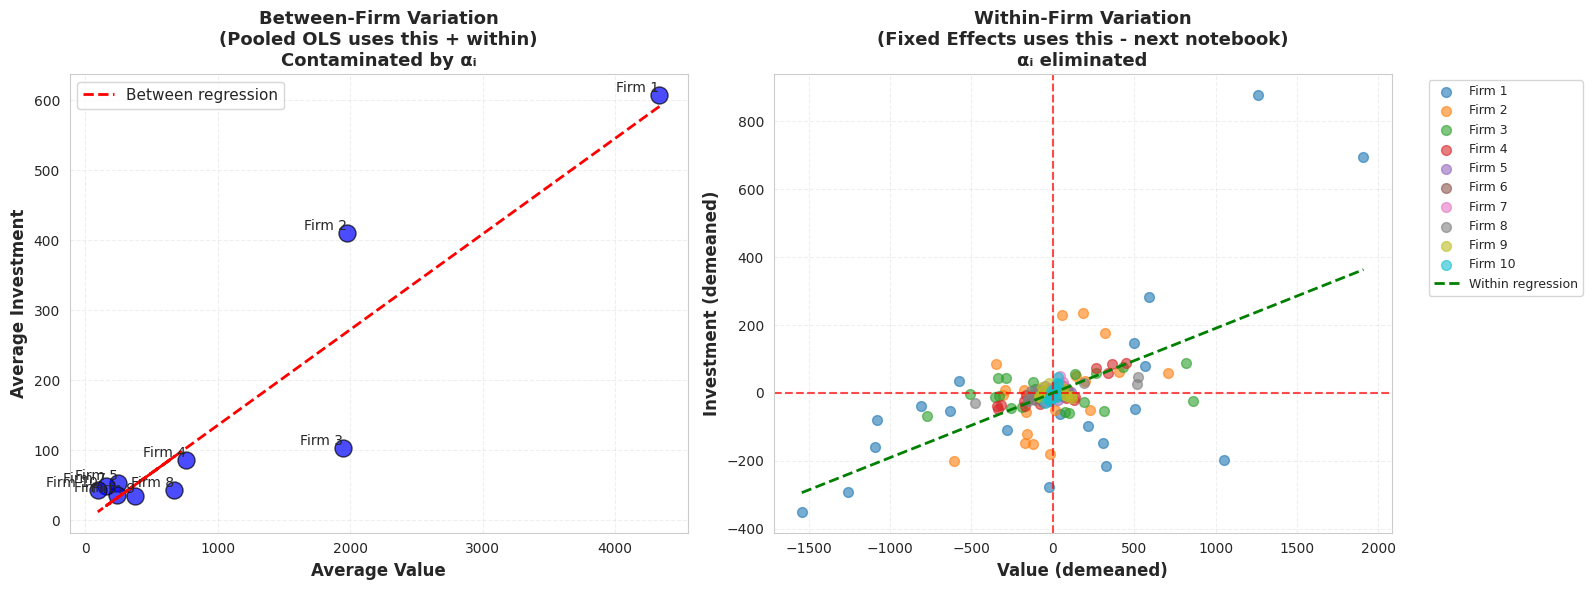

Plot saved to: ../../outputs/plots/01_within_between.png


In [13]:
# Compute firm-specific means
firm_means = data.groupby('firm')[['invest', 'value', 'capital']].mean().reset_index()

# Demean data (within transformation)
data_demeaned = data.copy()
for col in ['invest', 'value', 'capital']:
    data_demeaned[col + '_dm'] = data.groupby('firm')[col].transform(lambda x: x - x.mean())

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Between-firm relationship
ax1 = axes[0]
ax1.scatter(firm_means['value'], firm_means['invest'], s=150, alpha=0.7, color='blue', edgecolors='black')
for idx, row in firm_means.iterrows():
    ax1.annotate(f'Firm {int(row["firm"])}', 
                (row['value'], row['invest']), 
                fontsize=10, ha='right', va='bottom')

# Add regression line
z = np.polyfit(firm_means['value'], firm_means['invest'], 1)
p = np.poly1d(z)
ax1.plot(firm_means['value'], p(firm_means['value']), "r--", linewidth=2, label='Between regression')

ax1.set_xlabel('Average Value', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Investment', fontsize=12, fontweight='bold')
ax1.set_title('Between-Firm Variation\n(Pooled OLS uses this + within)\nContaminated by αᵢ', 
              fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3, linestyle='--')
ax1.legend(fontsize=11)

# Right plot: Within-firm relationship (demeaned)
ax2 = axes[1]
colors = plt.cm.tab10(np.linspace(0, 1, data['firm'].nunique()))
for i, firm_id in enumerate(sorted(data['firm'].unique())):
    firm_data = data_demeaned[data_demeaned['firm'] == firm_id]
    ax2.scatter(firm_data['value_dm'], firm_data['invest_dm'], 
               alpha=0.6, s=50, color=colors[i], label=f'Firm {firm_id}')

ax2.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# Add regression line
z2 = np.polyfit(data_demeaned['value_dm'], data_demeaned['invest_dm'], 1)
p2 = np.poly1d(z2)
x_range = np.linspace(data_demeaned['value_dm'].min(), data_demeaned['value_dm'].max(), 100)
ax2.plot(x_range, p2(x_range), "g--", linewidth=2, label='Within regression')

ax2.set_xlabel('Value (demeaned)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Investment (demeaned)', fontsize=12, fontweight='bold')
ax2.set_title('Within-Firm Variation\n(Fixed Effects uses this - next notebook)\nαᵢ eliminated', 
              fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()

# Save plot
plt.savefig(output_dir / '01_within_between.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to:", output_dir / '01_within_between.png')

**Interpretation**:

**Left plot (Between variation)**:
- Shows relationship using firm averages
- Includes both true effect of value AND firm-specific effects ($\alpha_i$)
- If high-value firms also have high $\alpha_i$ → slope is biased

**Right plot (Within variation)**:
- Shows relationship after removing firm means (demeaning)
- Eliminates $\alpha_i$ (constant for each firm)
- This is what Fixed Effects estimation uses!

**Key Question**: Do the slopes look similar?
- If slopes differ → evidence of $\alpha_i$ bias in Pooled OLS
- If slopes are similar → Pooled OLS might be okay (but still use clustered SE!)

### 4.3 When is Pooled OLS Appropriate?

Pooled OLS is valid when:

#### 1. No Unobserved Heterogeneity
- $\alpha_i = 0$ or $\alpha_i \perp X_{it}$ (orthogonality)
- Rare in practice with firm/individual data
- More plausible with randomized experiments

#### 2. Baseline for Comparison
- **Always estimate Pooled OLS as starting point**
- Compare to Fixed Effects (next notebook)
- Helps diagnose omitted variable bias

#### 3. Interest in Between Variation
- Time-invariant regressors (gender, country geography, genetic markers)
- Fixed Effects **cannot** estimate these (perfectly collinear with $\alpha_i$)
- Pooled OLS is only option (but interpret cautiously)

#### 4. Small T, Large N
- Fixed Effects loses degrees of freedom (estimates N-1 dummies)
- Pooled OLS more efficient if $\alpha_i \perp X_{it}$ assumption is valid
- Can test this assumption (Hausman test - next notebook)

---

**Recommendation**:
- Use Pooled OLS as **baseline**, not final model
- **Always use clustered SE** (by entity)
- Compare to Fixed Effects to check for bias
- If FE and Pooled OLS differ substantially → use FE

In [14]:
# Display final Pooled OLS results with clustered SE
print("FINAL POOLED OLS RESULTS (with clustered SE):")
print("=" * 80)
print(results_clustered.summary())
print("\n⚠️ Note: These estimates may be biased if αᵢ ~ Xᵢₜ")
print("Next notebook: Fixed Effects to eliminate this bias!")

FINAL POOLED OLS RESULTS (with clustered SE):
                        Pooled OLS Estimation Results                         
Formula: invest ~ value + capital
Model:   Pooled OLS
------------------------------------------------------------------------------
No. Observations:                 200
No. Entities:                      10
No. Time Periods:                  20
Degrees of Freedom:               197
R-squared:                     0.8090
Adj. R-squared:                0.8071
R-squared (overall):           0.8090
Standard Errors:            clustered
Variable        Coef.        Std.Err.     t        P>|t|    [0.025     0.975]    
------------------------------------------------------------------------------
Intercept          -10.2135     15.5601  -0.656  0.5123  -40.8991   20.4722 
value                0.0951      0.0122   7.775  0.0000    0.0710    0.1192 ***
capital              0.2940      0.0936   3.140  0.0019    0.1094    0.4787 **
Signif. codes:  0 '***' 0.001 '**' 0.01 '

---

## Section 5: Practical Exercises

### Exercise 5.1: Estimate Pooled OLS on Wage Data

**Instructions**:

Use the wage panel dataset to:
1. Explore the data (shape, variables, N, T)
2. Create a spaghetti plot of log_wage over time for first 10 individuals
3. Estimate Pooled OLS: `log_wage ~ experience + education + tenure`
4. Compare nonrobust vs clustered SE
5. Interpret coefficients: What is the return to education?

**Dataset**: `../../datasets/panel/wage_panel.csv`

In [15]:
# Exercise 5.1: YOUR CODE HERE

# 1. Load and explore wage data
wage_data = pd.read_csv('../../datasets/panel/wage_panel.csv')

# TODO: Explore the data
# print(f"Shape: {wage_data.shape}")
# print(f"N: {wage_data['person_id'].nunique()}, T: {wage_data['year'].nunique()}")
# print(wage_data.head())

# 2. TODO: Create spaghetti plot (first 10 individuals)


# 3. TODO: Estimate Pooled OLS
# model_wage = pb.PooledOLS("log_wage ~ experience + education + tenure",
#                           wage_data, 'person_id', 'year')

# 4. TODO: Compare SE


# 5. TODO: Interpret results


### Exercise 5.1 Solution (run after attempting)

Shape: (70, 6)
N: 10, T: 7

First 10 rows:
   person_id  year  log_wage  experience  education  tenure
0          1  1980    1.8952           2         12     0.5
1          1  1981    1.9459           3         12     1.5
2          1  1982    2.0015           4         12     2.5
3          1  1983    2.0541           5         12     3.5
4          1  1984    2.1072           6         12     4.5
5          1  1985    2.1589           7         12     5.5
6          1  1986    2.2134           8         12     6.5
7          2  1980    2.4023           4         16     1.0
8          2  1981    2.4512           5         16     2.0
9          2  1982    2.5089           6         16     3.0

Variable descriptions:
       person_id       year  log_wage  experience  education   tenure
count     70.000    70.0000   70.0000     70.0000     70.000  70.0000
mean       5.500  1983.0000    2.2216      7.1000     13.500   4.6000
std        2.893     2.0144    0.3020      3.6441      2.558   

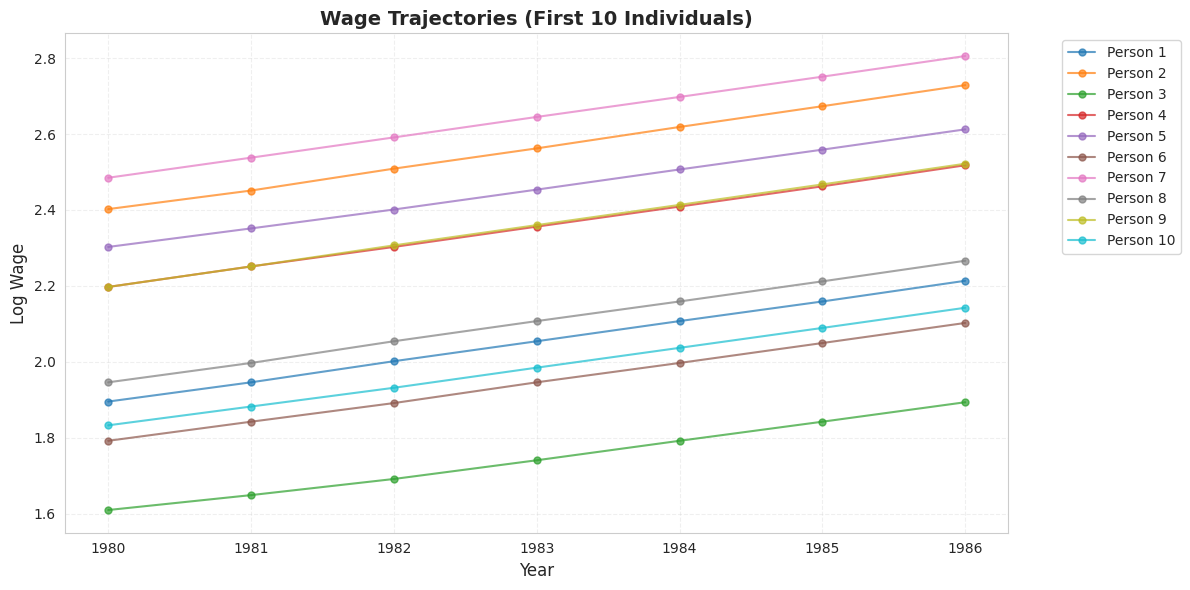


SE Comparison:
            Nonrobust  Clustered   Ratio
Intercept      0.1116     0.3700  3.3168
experience     0.0177     0.0506  2.8580
education      0.0112     0.0377  3.3598
tenure         0.0190     0.0492  2.5956


Interpretation (using clustered SE):
Return to education: 0.1039
Interpretation: 1 additional year of education is associated with 
                10.39% higher wages (on average)

Return to experience: -0.0287
Return to tenure: 0.0720

⚠️ Warning: These estimates may be biased due to unobserved ability (αᵢ)!


In [16]:
# Solution for Exercise 5.1

# 1. Explore data
wage_data = pd.read_csv('../../datasets/panel/wage_panel.csv')
print(f"Shape: {wage_data.shape}")
print(f"N: {wage_data['person_id'].nunique()}, T: {wage_data['year'].nunique()}")
print("\nFirst 10 rows:")
print(wage_data.head(10))
print("\nVariable descriptions:")
print(wage_data.describe())

# 2. Spaghetti plot (first 10 individuals)
plt.figure(figsize=(12, 6))
for person in sorted(wage_data['person_id'].unique())[:10]:
    person_data = wage_data[wage_data['person_id'] == person].sort_values('year')
    plt.plot(person_data['year'], person_data['log_wage'], 
             alpha=0.7, marker='o', markersize=5, linewidth=1.5,
             label=f'Person {person}')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Log Wage', fontsize=12)
plt.title('Wage Trajectories (First 10 Individuals)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 3. Estimate Pooled OLS
model_wage = pb.PooledOLS("log_wage ~ experience + education + tenure",
                          wage_data, 'person_id', 'year')
results_wage_nonrobust = model_wage.fit(cov_type='nonrobust')
results_wage_clustered = model_wage.fit(cov_type='clustered')

# 4. Compare SE
print("\nSE Comparison:")
print("=" * 70)
se_comp_wage = pd.DataFrame({
    'Nonrobust': results_wage_nonrobust.std_errors,
    'Clustered': results_wage_clustered.std_errors,
    'Ratio': results_wage_clustered.std_errors / results_wage_nonrobust.std_errors
})
print(se_comp_wage)

# 5. Interpret
print("\n\nInterpretation (using clustered SE):")
print("=" * 70)
print(f"Return to education: {results_wage_clustered.params['education']:.4f}")
print(f"Interpretation: 1 additional year of education is associated with ")
print(f"                {results_wage_clustered.params['education']*100:.2f}% higher wages (on average)")
print(f"\nReturn to experience: {results_wage_clustered.params['experience']:.4f}")
print(f"Return to tenure: {results_wage_clustered.params['tenure']:.4f}")
print("\n⚠️ Warning: These estimates may be biased due to unobserved ability (αᵢ)!")

### Exercise 5.2: Two-Way Clustering (Advanced)

**Instructions**:

1. Estimate Pooled OLS on Grunfeld data with two-way clustering (entity + time)
2. Compare one-way (entity only) vs two-way clustered SE
3. When would two-way clustering be necessary?

In [17]:
# Exercise 5.2: YOUR CODE HERE

# 1. TODO: Two-way clustering
# results_oneway = model.fit(cov_type='clustered')  # Default: cluster by entity
# results_twoway = model.fit(cov_type='twoway')     # Cluster by entity + time

# 2. TODO: Compare SE


# 3. TODO: Discussion


### Exercise 5.2 Solution (run after attempting)

In [18]:
# Solution for Exercise 5.2

# 1. Two-way clustering
results_oneway = model.fit(cov_type='clustered')  # Default: cluster by entity
results_twoway = model.fit(cov_type='twoway')     # Cluster by entity + time

# 2. Compare SE
print("One-way vs Two-way Clustered SE:")
print("=" * 70)
se_comp_clustering = pd.DataFrame({
    'One-way (entity)': results_oneway.std_errors,
    'Two-way (entity + time)': results_twoway.std_errors,
    'Ratio (Two-way/One-way)': results_twoway.std_errors / results_oneway.std_errors
})
print(se_comp_clustering)

# 3. Discussion
print("\n\nWhen to use two-way clustering:")
print("=" * 70)
print("Two-way clustering accounts for:")
print("• Within-entity correlation (already in one-way): E[εᵢₜ · εᵢₛ] ≠ 0")
print("• Within-time correlation (new): E[εᵢₜ · εⱼₜ] ≠ 0")
print("\nUse when concerned about:")
print("• Common macro shocks affecting all entities in year t")
print("• Cross-sectional correlation at each time period")
print("• Example: Financial crisis affecting all firms simultaneously")
print("\nNote: In Grunfeld data (N=10, T=20), two-way clustering may not change SE much")
print("      because time clustering is less important with small N")

One-way vs Two-way Clustered SE:
           One-way (entity)  Two-way (entity + time)  Ratio (Two-way/One-way)
Intercept           15.5601                  15.1395                   0.9730
value                0.0122                   0.0122                   0.9974
capital              0.0936                   0.0819                   0.8745


When to use two-way clustering:
Two-way clustering accounts for:
• Within-entity correlation (already in one-way): E[εᵢₜ · εᵢₛ] ≠ 0
• Within-time correlation (new): E[εᵢₜ · εⱼₜ] ≠ 0

Use when concerned about:
• Common macro shocks affecting all entities in year t
• Cross-sectional correlation at each time period
• Example: Financial crisis affecting all firms simultaneously

Note: In Grunfeld data (N=10, T=20), two-way clustering may not change SE much
      because time clustering is less important with small N


---

## Section 6: Summary and Next Steps

### Key Takeaways

#### 1. Panel Data Structure
- **Definition**: N entities × T periods
- **Advantages**: More observations, control for heterogeneity, study dynamics
- **Format**: Long format (each row = entity-time observation)

#### 2. Pooled OLS Model
- Treats all NT observations as independent
- Simple baseline estimator
- Ignores entity-specific effects ($\alpha_i$)

#### 3. Standard Errors in Panel Data
- **Always use clustered SE** (by entity)
- Nonrobust SE underestimate uncertainty (too small)
- Cluster by entity to account for serial correlation
- Consider two-way clustering if concerned about time effects

#### 4. Limitations of Pooled OLS
- **Biased** if $\alpha_i$ is correlated with $X_{it}$ (omitted variable bias)
- Uses both between and within variation (contaminated by $\alpha_i$)
- Solution: Fixed Effects (next notebook)

#### 5. When to Use Pooled OLS
- **Baseline for comparison** (always start here)
- Time-invariant regressors (FE cannot estimate these)
- When $\alpha_i \perp X_{it}$ is plausible (rare in practice)
- Compare to FE to diagnose bias

---

### Next Notebook: Fixed Effects

In the next tutorial, you will learn:
- How to **eliminate** $\alpha_i$ via demeaning (within transformation)
- Estimate **Fixed Effects** models
- **Test** whether FE is necessary (F-test, Hausman test)
- Compare Pooled OLS vs Fixed Effects estimates
- Understand when to use each model

**File**: `02_fixed_effects.ipynb`

In [19]:
# Summary
print("=" * 80)
print("KEY TAKEAWAYS - POOLED OLS INTRODUCTION")
print("=" * 80)
print("1. Panel data: N entities × T periods (more info than cross-section)")
print("2. Pooled OLS: Treats NT obs as independent (baseline estimator)")
print("3. Always use CLUSTERED SE by entity (nonrobust SE are wrong!)")
print("4. Pooled OLS is BIASED if αᵢ ~ Xᵢₜ (omitted variable bias)")
print("5. Next: Fixed Effects to eliminate unobserved heterogeneity")
print("=" * 80)
print("\nCongratulations! You've completed Tutorial 01: Pooled OLS Introduction")
print("Next: Tutorial 02 - Fixed Effects Models")

KEY TAKEAWAYS - POOLED OLS INTRODUCTION
1. Panel data: N entities × T periods (more info than cross-section)
2. Pooled OLS: Treats NT obs as independent (baseline estimator)
3. Always use CLUSTERED SE by entity (nonrobust SE are wrong!)
4. Pooled OLS is BIASED if αᵢ ~ Xᵢₜ (omitted variable bias)
5. Next: Fixed Effects to eliminate unobserved heterogeneity

Congratulations! You've completed Tutorial 01: Pooled OLS Introduction
Next: Tutorial 02 - Fixed Effects Models


---

## References

### Academic References
1. **Wooldridge, J. M. (2010)**. *Econometric Analysis of Cross Section and Panel Data*, 2nd Edition. MIT Press. Chapter 10.
2. **Baltagi, B. H. (2021)**. *Econometric Analysis of Panel Data*, 6th Edition. Springer. Chapter 2.
3. **Cameron, A. C., & Trivedi, P. K. (2005)**. *Microeconometrics: Methods and Applications*. Cambridge University Press. Chapter 21.
4. **Moulton, B. R. (1990)**. "An Illustration of a Pitfall in Estimating the Effects of Aggregate Variables on Micro Units". *Review of Economics and Statistics*, 72(2), 334-338.
5. **Bertrand, M., Duflo, E., & Mullainathan, S. (2004)**. "How Much Should We Trust Differences-in-Differences Estimates?" *Quarterly Journal of Economics*, 119(1), 249-275.

### Software Documentation
- **PanelBox Documentation**: [https://panelbox.readthedocs.io](https://panelbox.readthedocs.io)
- **pandas**: [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)
- **statsmodels**: [https://www.statsmodels.org/stable/index.html](https://www.statsmodels.org/stable/index.html)

### Dataset Source
- **Grunfeld, Y. (1958)**. "The Determinants of Corporate Investment". *Unpublished Ph.D. dissertation*, University of Chicago.

---

**End of Tutorial 01**